# MAPM SPE FITTING TECHNIQUE
This notebook demonstrates how to fit the Single Photo-Electron Pulse Area Spectrum with scipy.optimise.curve_fit using the latest MAPM fitting equation.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import poisson, norm as gaussian
from scipy.optimize import curve_fit
import pandas as pd
from IPython.display import display
from pandas.tools.plotting import table

In [2]:
hist_a = np.array([   6,    6,    5,   13,    4,   10,   20,   62,  276,  889, 1102,
        678,  378,  299,  329,  347,  349,  368,  344,  363,  319,  298,
        291,  260,  268,  212,  204,  203,  190,  161,  153,  143,  129,
        133,  116,   83,  104,   83,   92,   64])
edges_a = np.array([-20., -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,
         2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
        24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,
        46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.])
between_a = (edges_a[1:] + edges_a[:-1]) / 2

In [3]:
hist_a2 = np.array([   1,    3,    7,    5,    3,   10,   18,   69,  302,  982, 1322,
        660,  381,  332,  314,  357,  340,  343,  321,  317,  297,  300,
        303,  246,  224,  230,  200,  203,  182,  152,  164,  153,  105,
        108,  108,   83,  102,   83,   79,   69])
edges_a2 = np.array([-20., -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,
         2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
        24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,
        46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.])
between_a2 = (edges_a2[1:] + edges_a2[:-1]) / 2

In [4]:
hist_a3 = np.array([   4,    2,    4,    5,    9,    8,   20,   76,  298, 1000, 1280,
        709,  393,  341,  328,  330,  352,  334,  348,  317,  328,  280,
        261,  271,  248,  234,  203,  206,  169,  146,  146,  125,  108,
        121,   82,   89,   72,   78,   70,   58])
edges_a3 = np.array([-20., -18., -16., -14., -12., -10.,  -8.,  -6.,  -4.,  -2.,   0.,
         2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,  22.,
        24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,
        46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.])
between_a3 = (edges_a3[1:] + edges_a3[:-1]) / 2

In [5]:
def pedestal_signal(x, norm, eped, eped_sigma, lambda_):
    """
    Obtain the signal provided by the pedestal in the pulse spectrum.

    Parameters
    ----------
    x : 1darray
        The x values to evaluate at
    norm : float
        Integral of the zeroth peak in the distribution, represents p(0)
    eped : float
        Distance of the zeroth peak from the origin
    eped_sigma : float
        Sigma of the zeroth peak, represents electronic noise of the system
    lambda_ : float
        Poisson mean

    Returns
    -------
    signal : ndarray
        The y values of the signal provided by the pedestal.

    """
    p_ped = poisson.pmf(0, lambda_)
    signal = norm * p_ped * gaussian.pdf(x, eped, eped_sigma) / eped_sigma
    return signal

In [6]:
def pe_signal(k, x, norm, eped, eped_sigma, spe, spe_sigma, lambda_):
    """
    Obtain the signal provided by photoelectrons in the pulse spectrum.

    Parameters
    ----------
    k : int or 1darray
        The NPEs to evaluate. A list of NPEs can be passed here, provided it
        is broadcast as [:, None], and the x input is broadcast as [None, :],
        the return value will then be a shape [k.size, x.size].

        k must be greater than or equal to 1.
    x : 1darray
        The x values to evaluate at
    norm : float
        Integral of the zeroth peak in the distribution, represents p(0)
    eped : float
        Distance of the zeroth peak from the origin
    eped_sigma : float
        Sigma of the zeroth peak, represents electronic noise of the system
    spe : float
        Signal produced by 1 photo-electron
    spe_sigma : float
        Spread in the number of photo-electrons incident on the MAPMT
    lambda_ : float
        Poisson mean

    Returns
    -------
    signal : ndarray
        The y values of the signal provided by the photoelectrons. If k is an
        integer, this will have same shape as x. If k is an array,
        and k and x are broadcase correctly, this will have
        shape [k.size, x.size].

    """
    # Obtain poisson distribution
    # TODO: could do something smarter here depending on lambda_
    p = poisson.pmf(np.arange(11), lambda_)

    pe = eped + k * spe
    pe_sigma = np.sqrt(k * (spe_sigma ** 2) + (eped_sigma ** 2))
    signal = norm * p[k] * gaussian.pdf(x, pe, pe_sigma) / pe_sigma
    return signal

In [7]:
def mapm_spe_fit(x, norm, eped, eped_sigma, spe, spe_sigma, lambda_):
    """
    Fit for the SPE spectrum of a MAPM

    Parameters
    ----------
    x
    norm : float
        Integral of the zeroth peak in the distribution, represents p(0)
    eped : float
        Distance of the zeroth peak from the origin
    eped_sigma : float
        Sigma of the zeroth peak, represents electronic noise of the system
    spe : float
        Signal produced by 1 photo-electron
    spe_sigma : float
        Spread in the number of photo-electrons incident on the MAPMT
    lambda_ : float
        Poisson mean

    Returns
    -------

    """

    # Obtain pedestal signal
    params = [norm, eped, eped_sigma, lambda_]
    ped_s = pedestal_signal(x, *params)

    # Obtain pe signal
    k = np.arange(1, 11)
    params = [norm, eped, eped_sigma, spe, spe_sigma, lambda_]
    pe_s = pe_signal(k[:, None], x[None, :], *params).sum(0)

    signal = ped_s + pe_s

    return signal

In [8]:
def mapm_spe_fit_multi(x, norm, eped, eped_sigma, spe, spe_sigma, lambda_, norm2, lambda_2, norm3, lambda_3):
    l1 = between_a.size
    l2 = between_a2.size
    l3 = between_a3.size
    
    x1 = x[:l1]
    x2 = x[l1:l1+l2]
    x3 = x[l1+l2:l1+l2+l3]
    
    multi = np.vstack([mapm_spe_fit(x1, norm, eped, eped_sigma, spe, spe_sigma, lambda_),
                   mapm_spe_fit(x2, norm2, eped, eped_sigma, spe, spe_sigma, lambda_2),
                   mapm_spe_fit(x3, norm3, eped, eped_sigma, spe, spe_sigma, lambda_3)])
    return multi.ravel()

## Single Fit

In [9]:
def scipy_fit(x, y, p0):
    coeff, var_matrix = curve_fit(mapm_spe_fit, x, y, p0=p0)
    scipy_y_result = mapm_spe_fit(x, *coeff)
    return scipy_y_result, coeff

In [10]:
p0 = [200000, 0, 5, 20, 5, 1]
scipy_y_result, coeff1 = scipy_fit(between_a, hist_a, p0)
scipy_y_result2, coeff2 = scipy_fit(between_a2, hist_a2, p0)
scipy_y_result3, coeff3 = scipy_fit(between_a3, hist_a3, p0)

## Multi Fit

In [14]:
def scipy_fit_multi_lambda(x_list, y_list, p0):
    x_data = np.hstack(x_list)
    y_data = np.hstack(y_list)

    s = []
    last = 0
    for xi in x_list:
        current = xi.size + last
        s.append(np.s_[last:current])
        last = current

    def mapm_spe_fit_multi_lambda(x, norm, eped, eped_sigma, spe, spe_sigma, lambda_,
                           norm2, lambda_2, norm3, lambda_3):
        
        x1 = x[s[0]]
        x2 = x[s[1]]
        x3 = x[s[2]]

        multi = np.hstack(
            [mapm_spe_fit(x1, norm, eped, eped_sigma, spe, spe_sigma, lambda_),
             mapm_spe_fit(x2, norm2, eped, eped_sigma, spe, spe_sigma, lambda_2),
             mapm_spe_fit(x3, norm3, eped, eped_sigma, spe, spe_sigma, lambda_3)])
        return multi

    coeff_m, var_matrix = curve_fit(mapm_spe_fit_multi_lambda, x_data, y_data, p0=p0)
    scipy_y_result_multi_all = mapm_spe_fit_multi_lambda(x_data, *coeff_m)

    scipy_y_result_multi = scipy_y_result_multi_all[s[0]]
    scipy_y_result_multi2 = scipy_y_result_multi_all[s[1]]
    scipy_y_result_multi3 = scipy_y_result_multi_all[s[2]]
    
    return scipy_y_result_multi, scipy_y_result_multi2, scipy_y_result_multi3, coeff_m

In [15]:
x_list = [between_a, between_a2, between_a3]
y_list = [hist_a, hist_a2, hist_a3]
p0 = [200000, 0, 5, 20, 5, 1, 200000, 1, 200000, 1]
scipy_y_result_multi, scipy_y_result_multi2, scipy_y_result_multi3, coeff_m = scipy_fit_multi_lambda(x_list, y_list, p0)

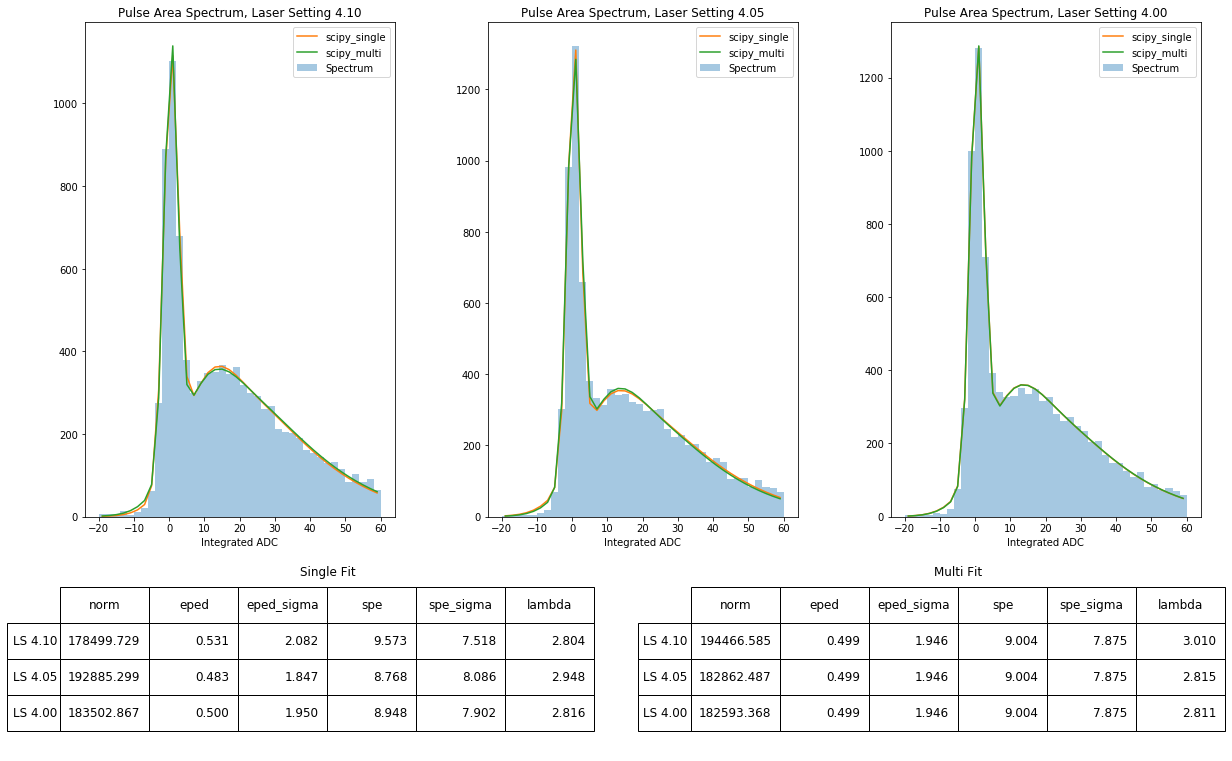

In [13]:
fig_m = plt.figure(figsize=(20, 20))
fig_m.subplots_adjust(wspace=0.3)
ax_m1 = fig_m.add_subplot(2, 3, 1)
ax_m1.set_title('Pulse Area Spectrum, Laser Setting 4.10')
ax_m1.set_xlabel('Integrated ADC')
ax_m2 = fig_m.add_subplot(2, 3, 2)
ax_m2.set_title('Pulse Area Spectrum, Laser Setting 4.05')
ax_m2.set_xlabel('Integrated ADC')
ax_m3 = fig_m.add_subplot(2, 3, 3)
ax_m3.set_title('Pulse Area Spectrum, Laser Setting 4.00')
ax_m3.set_xlabel('Integrated ADC')
ax_t1 = fig_m.add_subplot(6, 2, 7)
ax_t1.set_title('Single Fit')
ax_t2 = fig_m.add_subplot(6, 2, 8)
ax_t2.set_title('Multi Fit')

ax_m1.hist(between_a, edges_a, weights=hist_a, alpha=0.4, label="Spectrum")
ax_m1.plot(between_a, scipy_y_result, label="scipy_single")
ax_m1.plot(between_a, scipy_y_result_multi, label="scipy_multi")
ax_m1.legend(loc=1)

ax_m2.hist(between_a2, edges_a2, weights=hist_a2, alpha=0.4, label="Spectrum")
ax_m2.plot(between_a2, scipy_y_result2, label="scipy_single")
ax_m2.plot(between_a2, scipy_y_result_multi2, label="scipy_multi")
ax_m2.legend(loc=1)

ax_m3.hist(between_a3, edges_a3, weights=hist_a3, alpha=0.4, label="Spectrum")
ax_m3.plot(between_a3, scipy_y_result3, label="scipy_single")
ax_m3.plot(between_a3, scipy_y_result_multi3, label="scipy_multi")
ax_m3.legend(loc=1)

table_data = [[*coeff1], [*coeff2], [*coeff3]]
table_data = [['%.3f' % j for j in i] for i in table_data]
table_col=("norm", "eped", "eped_sigma", "spe", "spe_sigma", "lambda")
table_row=("LS 4.10", "LS 4.05", "LS 4.00")
ax_t1.axis('tight')
ax_t1.axis('off')
table1 = ax_t1.table(cellText=table_data,colLabels=table_col, rowLabels=table_row,loc='center')
table1.scale(1.1,3)
table1.auto_set_font_size(False)
table1.set_fontsize(12)

table_data = [[coeff_m[0], coeff_m[1], coeff_m[2], coeff_m[3], coeff_m[4], coeff_m[5]],
              [coeff_m[6], coeff_m[1], coeff_m[2], coeff_m[3], coeff_m[4], coeff_m[7]],
              [coeff_m[8], coeff_m[1], coeff_m[2], coeff_m[3], coeff_m[4], coeff_m[9]]]
table_data = [['%.3f' % j for j in i] for i in table_data]
table_col=("norm", "eped", "eped_sigma", "spe", "spe_sigma", "lambda")
table_row=("LS 4.10", "LS 4.05", "LS 4.00")
ax_t2.axis('tight')
ax_t2.axis('off')
table2 = ax_t2.table(cellText=table_data,colLabels=table_col, rowLabels=table_row,loc='center')
table2.scale(1.1,3)
table2.auto_set_font_size(False)
table2.set_fontsize(12)